<a href="https://colab.research.google.com/github/LizLian/from_scratch_2025/blob/main/Bigram_%26_MLP_012026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Bigram Template

1. Read in the name.txt file, build a dictionary to store the bigram and their count from the dataset.
2. Sample from the model. Steps when encounters the end of sentence symbol.
3. write the negative log likelihood loss function. (cross entropy).
4. convert the bigram model to neural net. (hint: convert x to one hot vectors, initialize weights, logits = xenc @ W. Update W.data in backward pass)
5. sample the model again to see the results after optimization.

In [4]:
data = []
with open("names.txt") as infile:
  for line in infile:
    data.append(line.strip())

In [5]:
data[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
vocab = set(".".join(data))

In [7]:
stoi = {}
itos = {}
for i, c in enumerate(sorted(vocab)):
  stoi[c] = i
  itos[i] = c


In [ ]:
bigrams = torch.zeros((len(vocab), len(vocab)))
for name in data:
  chrs = "." + name + "."
  for ch1, ch2 in zip(chrs, chrs[1:]):
    bigrams[stoi[ch1], stoi[ch2]] += 1

In [ ]:
# @title Sample from the model
start_chr_prob = bigrams[0].float()/bigrams[0].sum()
start_chr_prob

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [ ]:
import torch
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  ix = 0
  out = []
  while True:
    p = bigrams[ix].float()/bigrams[ix].sum()
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    c = itos[ix]
    out.append(c)
    if ix == 0:
      break
  print("".join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [ ]:
# @title Negative Log likelihood
nll = -torch.log(p).sum()
nll

tensor(109.1046)

In [ ]:
import torch.nn.functional as F

xs = []
ys = []
for name in data:
  chrs = "." + name + "."
  for ch1, ch2 in zip(chrs, chrs[1:]):
    xs.append(stoi[ch1])
    ys.append(stoi[ch2])

xs = torch.tensor(xs)
num = xs.nelement()
ys = torch.tensor(ys)
W = torch.randn((27, 27), generator=g, requires_grad=True) # random select from a normal distribution (mean=0, std=1)

for i in range(100): # 50 epochs
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W
  counts = logits.exp()
  probs = counts/counts.sum(dim=1, keepdim=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  if i%10==0:
    print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data += -70 * W.grad


3.625509023666382
2.6165945529937744
2.5435054302215576
2.5182595252990723
2.5057497024536133
2.4984216690063477
2.493731737136841
2.4905762672424316
2.4883792400360107
2.486804962158203


In [ ]:
# @title Model Generate Function
for i in range(5):
  ix = 0
  out = []
  while True:
    # p = bigrams[ix].float()/bigrams[ix].sum()
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts/counts.sum(dim=1, keepdim=True)
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    c = itos[ix]
    out.append(c)
    if ix == 0:
      break
  print("".join(out))

ckae.
a.
hidaruyia.
ezera.
duillpwghanamahu.


In [1]:
# @title MLP

Update the bigram model to MLP
1. block size: context length - how many characters do we take to predict the next one?
2. construct x and y training dataset (validation and test set too)
3. hidden layer = emb @ W1 + b1, logits = h @ W2 + b2.
4. compute loss
5. collect all paramters, update each parameter's data.
6. plot train loss with steps
7. evaluate train loss and validation loss.
8. sample from the model.


In [2]:
block_size = 3
data = []
with open("names.txt") as infile:
  for line in infile:
    data.append(line.strip())

vocab = set(".".join(data))
stoi = {}
itos = {}
for i, c in enumerate(sorted(vocab)):
  stoi[c] = i
  itos[i] = c


def build_dataset(data):
  context = [0] * block_size # print(stoi["."])
  X, Y = [], []
  for name in data:
    for c in name + ".":
      ix = stoi[c]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  return X, Y


Xtr, Ytr = build_dataset(data[:int(len(data) * 0.8)])
Xdev, Ydev = build_dataset(data[int(len(data) * 0.8): int(len(data) * 0.9)])
Xtest, Ytest = build_dataset(data[int(len(data) * 0.9): ])

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
Xtr, Ytr = torch.tensor(Xtr), torch.tensor(Ytr)
# Xtr = F.one_hot(Xtr, num_classes=len(vocab))
Xtr[:2]

tensor([[0, 0, 0],
        [0, 0, 5]])

In [5]:
import random
g = torch.Generator().manual_seed(2147483647)
emb = torch.randn(size=(27, 100), generator=g)
W1 = torch.randn(size=(300, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(size=(100, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [emb, W1, b1, W2, b2]
for param in params:
  param.requires_grad = True

In [6]:
#  @title Manual derive cross entropy loss
batch_size = Xtr.shape[0]
h = torch.tanh(emb[Xtr].view(batch_size,-1) @ W1 + b1)
logits = h@W2 + b2
# counts = (logits - logits.max(dim=-1).values.view(-1,1)).exp()
counts = logits.exp()
probs = counts/counts.sum(dim=-1, keepdim=True)
loss = -probs[torch.arange(Ytr.shape[0]), Ytr].log().mean()
loss

tensor(20.0907, grad_fn=<NegBackward0>)

In [8]:
# @title Training Loop
def train(X, Y, epoch):
  stepi = []
  lossi = []
  for i in range(epoch):
    mini_batch = torch.randint(0, len(X), size=(32,))
    x = X[mini_batch]
    y = Y[mini_batch]
    h = torch.tanh(emb[x].view(mini_batch.shape[0],-1) @ W1 + b1)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)

    # backward loss
    for param in params:
      param.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for param in params:
      param.data += -lr * param.grad

    stepi.append(i)
    lossi.append(loss.item())
  print(loss.item())
  return stepi, lossi

In [9]:
stepi, lossi = train(Xtr, Ytr, 200000)

2.26755952835083


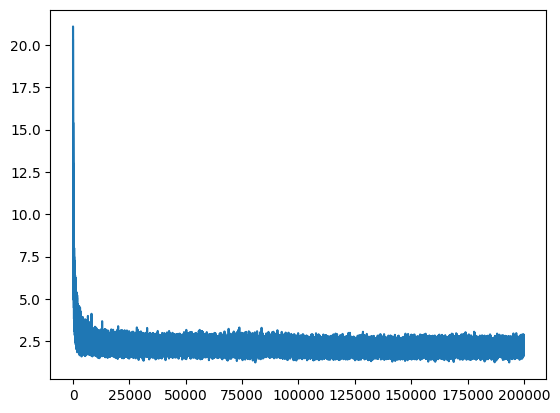

In [10]:
plt.plot(stepi, lossi)

In [13]:
# @title Evaluate dev loss
Xdev, Ydev = torch.tensor(Xdev), torch.tensor(Ydev)
h = torch.tanh(emb[Xdev].view(Xdev.shape[0],-1) @ W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.398454427719116


In [18]:
# @title Sample from the model
for i in range(20):
  out = []
  context = [0] * block_size
  while True:
    h = torch.tanh(emb[torch.tensor(context)].view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print("".join(itos[i] for i in out))


ahli.
aliza.
axon.
ale.
aya.
alifie.
orson.
crae.
ady.
asyleette.
asardyn.
xaedo.
alandahzina.
alani.
phen.
anda.
chenna.
jecenzgendaesley.
celynn.
elie.
